# Analyze Sports Data

methods for analyzing sports data using Python. In this notebook will see some basic concepts. These can be broken down into three areas:

1. How to code sports data so that you can apply statistical methods
2. The use of statistical methods
3. The interpretation of results

## The Pythagorean Expectation
The Pythagorean expectation is an idea devised by the famous baseball analyst, Bill James, but it can in fact be applied to any sport.

In any sports league, teams win games by accumulating a higher total than opponent. In baseball and cricket the relevant totals are runs, in basketball it is points, and in soccer and hockey it is goals (by "hockey" we mean here what the world outside of the US and Canada usually calls ice hockey, but in fact the same is true in field hockey).

The Pythagorean expectation can be described thus: in any season, the percentage of games won will be proportional to the square of total runs/points/goals scored by the team squared divided by the sum of total runs/points/goals scored by the team squared plus total runs/points/goals conceded by the team squared.

or wpc = TF2 / ( TF2 + TA2 )

Where TF is runs/points/goals scored and TA is runs/points/goals conceded.

This is a concept which can help to explain not only why teams are successful, but also can be used as the basis for predicting results in the future.

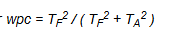

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
mlb_raw = pd.read_excel("./Raw_data/Retrosheet MLB game log 2018.xlsx")
mlb_raw.head()

,Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,...,HomeBatting7Name,HomeBatting7Position,HomeBatting8PlayerID,HomeBatting8Name,HomeBatting8Position,HomeBatting9PlayerID,HomeBatting9Name,HomeBatting9Position,AdditionalInfo,AcquisitionInfo
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,...,Nick Ahmed,6,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,...,Dansby Swanson,6,flahr001,Ryan Flaherty,5,tehej001,Julio Teheran,1,NaN,Y
2,20180329,0,Thu,SFN,NL,1,LAN,NL,1,1,...,Yasmani Grandal,2,forsl001,Logan Forsythe,5,kersc001,Clayton Kershaw,1,NaN,Y
3,20180329,0,Thu,CHN,NL,1,MIA,NL,1,8,...,Miguel Rojas,6,wallc001,Chad Wallach,2,urenj001,Jose Urena,1,NaN,Y
4,20180329,0,Thu,SLN,NL,1,NYN,NL,1,4,...,Kevin Plawecki,2,syndn001,Noah Syndergaard,1,rosaa003,Amed Rosario,6,NaN,Y


In [3]:
headers = mlb_raw.columns.to_list()
print(len(headers))

161


In [4]:
check_nas = mlb_raw.isna().sum()
check_nas[check_nas > 0]

CompletionInfo      2429
ForfeitInfo         2431
ProtestInfo         2431
Umpire2BID             1
UmpireLFID          2429
UmpireRFID          2429
SavingPitcherID     1187
GameWinningRBIID     118
AdditionalInfo      2419
dtype: int64


* https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
* https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

In [5]:
mlb_raw["Date"] = pd.to_datetime(mlb_raw["Date"],format="%Y%m%d")
mlb_raw["Date"].min()

Timestamp('2018-03-29 00:00:00')

In [6]:
mlb_columns = mlb_raw.columns
print(mlb_columns)

Index(['Date', 'DoubleHeader', 'DayOfWeek', 'VisitingTeam',
       'VisitingTeamLeague', 'VisitingTeamGameNumber', 'HomeTeam',
       'HomeTeamLeague', 'HomeTeamGameNumber', 'VisitorRunsScored',
       ...
       'HomeBatting7Name', 'HomeBatting7Position', 'HomeBatting8PlayerID',
       'HomeBatting8Name', 'HomeBatting8Position', 'HomeBatting9PlayerID',
       'HomeBatting9Name', 'HomeBatting9Position', 'AdditionalInfo',
       'AcquisitionInfo'],
      dtype='object', length=161)


In [7]:
mlb = mlb_raw[["Date","HomeTeam","VisitingTeam","HomeRunsScore","VisitorRunsScored"]]
print(mlb.shape)
mlb.head(20)

(2431, 5)


,Date,HomeTeam,VisitingTeam,HomeRunsScore,VisitorRunsScored
0,2018-03-29,ARI,COL,8,2
1,2018-03-29,ATL,PHI,8,5
2,2018-03-29,LAN,SFN,0,1
3,2018-03-29,MIA,CHN,4,8
4,2018-03-29,NYN,SLN,9,4
5,2018-03-29,SDN,MIL,1,2
6,2018-03-29,BAL,MIN,3,2
7,2018-03-29,KCA,CHA,7,14
8,2018-03-29,OAK,ANA,6,5
9,2018-03-29,SEA,CLE,2,1


In [8]:
mlb["H_Win"] = np.where(mlb["HomeRunsScore"] > mlb["VisitorRunsScored"],1,0)
mlb["V_Win"] = np.where(mlb["H_Win"] == 1,0,1)
mlb["Game_count"] = 1
mlb.head(20)

C:\Users\andre\AppData\Local\Temp\ipykernel_492\1513652259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlb["H_Win"] = np.where(mlb["HomeRunsScore"] > mlb["VisitorRunsScored"],1,0)
C:\Users\andre\AppData\Local\Temp\ipykernel_492\1513652259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mlb["V_Win"] = np.where(mlb["H_Win"] == 1,0,1)
C:\Users\andre\AppData\Local\Temp\ipykernel_492\1513652259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,Date,HomeTeam,VisitingTeam,HomeRunsScore,VisitorRunsScored,H_Win,V_Win,Game_count
0,2018-03-29,ARI,COL,8,2,1,0,1
1,2018-03-29,ATL,PHI,8,5,1,0,1
2,2018-03-29,LAN,SFN,0,1,0,1,1
3,2018-03-29,MIA,CHN,4,8,0,1,1
4,2018-03-29,NYN,SLN,9,4,1,0,1
5,2018-03-29,SDN,MIL,1,2,0,1,1
6,2018-03-29,BAL,MIN,3,2,1,0,1
7,2018-03-29,KCA,CHA,7,14,0,1,1
8,2018-03-29,OAK,ANA,6,5,1,0,1
9,2018-03-29,SEA,CLE,2,1,1,0,1


In [9]:
mlb_home = mlb.groupby("HomeTeam").agg({"HomeRunsScore":"sum","VisitorRunsScored":"sum","H_Win":"sum","Game_count":"sum"}).reset_index()
mlb_home = mlb_home.rename(columns={"HomeTeam":"Team","HomeRunsScore":"RunsMade","VisitorRunsScored":"RunsRecived"})
mlb_home

,Team,RunsMade,RunsRecived,H_Win,Game_count
0,ANA,355,355,42,81
1,ARI,359,328,40,81
2,ATL,391,357,43,81
3,BAL,339,411,28,81
4,BOS,468,322,57,81
5,CHA,321,409,30,81
6,CHN,385,349,51,82
7,CIN,385,418,37,81
8,CLE,443,334,49,81
9,COL,445,404,47,81


In [10]:
mlb_away = mlb.groupby("VisitingTeam").agg({"VisitorRunsScored":"sum","HomeRunsScore":"sum","V_Win":"sum","Game_count":"sum"}).reset_index()
mlb_away = mlb_away.rename(columns={"VisitingTeam":"Team","HomeRunsScore":"RunsRecived","VisitorRunsScored":"RunsMade"})
mlb_away

,Team,RunsMade,RunsRecived,V_Win,Game_count
0,ANA,366,367,38,81
1,ARI,334,316,42,81
2,ATL,368,300,47,81
3,BAL,283,481,19,81
4,BOS,408,325,51,81
5,CHA,335,439,32,81
6,CHN,376,296,44,81
7,CIN,311,401,30,81
8,CLE,375,314,42,81
9,COL,335,341,44,82


In [11]:
mlb_home = mlb_home.set_index("Team")
mlb_away = mlb_away.set_index("Team")

mlb_teams = mlb_home.join(mlb_away,on="Team",lsuffix="_home",rsuffix="_away")
mlb_teams = mlb_teams.reset_index()
mlb_teams

,Team,RunsMade_home,RunsRecived_home,H_Win,Game_count_home,RunsMade_away,RunsRecived_away,V_Win,Game_count_away
0,ANA,355,355,42,81,366,367,38,81
1,ARI,359,328,40,81,334,316,42,81
2,ATL,391,357,43,81,368,300,47,81
3,BAL,339,411,28,81,283,481,19,81
4,BOS,468,322,57,81,408,325,51,81
5,CHA,321,409,30,81,335,439,32,81
6,CHN,385,349,51,82,376,296,44,81
7,CIN,385,418,37,81,311,401,30,81
8,CLE,443,334,49,81,375,314,42,81
9,COL,445,404,47,81,335,341,44,82


In [15]:
mlb_teams["RunsMade"] = mlb_teams["RunsMade_home"] + mlb_teams["RunsMade_away"]
mlb_teams["RunsRecived"] = mlb_teams["RunsRecived_home"] + mlb_teams["RunsRecived_away"]
mlb_teams["Games"] = mlb_teams["Game_count_home"] + mlb_teams["Game_count_away"]
mlb_teams["Wins"] = mlb_teams["H_Win"] + mlb_teams["V_Win"]
mlb_teams["Loss"] = mlb_teams["Games"] - mlb_teams["Wins"]

team_overall = mlb_teams[["Team","Games","Wins","Loss","RunsMade","RunsRecived"]]
team_overall


,Team,Games,Wins,Loss,RunsMade,RunsRecived
0,ANA,162,80,82,721,722
1,ARI,162,82,80,693,644
2,ATL,162,90,72,759,657
3,BAL,162,47,115,622,892
4,BOS,162,108,54,876,647
5,CHA,162,62,100,656,848
6,CHN,163,95,68,761,645
7,CIN,162,67,95,696,819
8,CLE,162,91,71,818,648
9,COL,163,91,72,780,745
